# EDA - Credit Card Data

**Task 1: Data Analysis and Preprocessing**

This notebook explores the bank transaction dataset, performs data cleaning, EDA, data transformation, and handles class imbalance.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import os

# Ensure reports/figures directory exists
os.makedirs('../reports/figures', exist_ok=True)

# Load cleaned data
df = pd.read_csv('../data/processed/creditcard_cleaned.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1000, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.597425,0.577080,1.084791,-0.117295,-0.700067,1.352800,0.356585,1.604807,-0.962049,...,1.696396,-1.595878,0.081008,-2.657913,0.298611,-0.128444,-0.730955,1.622748,392.669709,0
1,1,-1.500615,1.500473,-0.705170,-2.452034,-1.090362,-0.135863,0.161411,-0.248332,0.237305,...,0.193966,1.379339,1.161947,1.002978,0.728258,1.134483,1.228318,-0.774539,142.816328,0
2,2,1.802297,0.988842,-0.202926,-0.521235,0.379104,1.109564,-0.659125,-1.186604,0.292160,...,1.389516,0.396779,-0.523570,-1.357795,-0.104191,1.557476,-1.707645,-0.603107,98.201292,0
3,3,0.146733,-0.646601,0.054425,-0.191837,1.961490,-0.430392,-0.045269,-2.470266,-0.675802,...,0.872988,-0.075015,0.128638,-1.539852,0.716524,1.335501,1.204451,1.373543,237.484641,0
4,4,0.197591,1.094350,-0.961081,1.749392,-0.365238,0.486359,0.528776,1.108628,-0.633242,...,-0.582265,1.271014,1.569117,0.430780,1.313077,-0.694390,0.448081,-0.459802,90.217633,0


## 1. Data Cleaning

### Missing Values
Justification: Missing values in transaction data would compromise model integrity. We drop rows with missing values to ensure data quality.

### Duplicates
Justification: Duplicate transactions would bias the model. Each transaction should be unique.

### Data Types
- All features are numerical (Time, V1-V28, Amount, Class)
- Data types are correct and ready for analysis

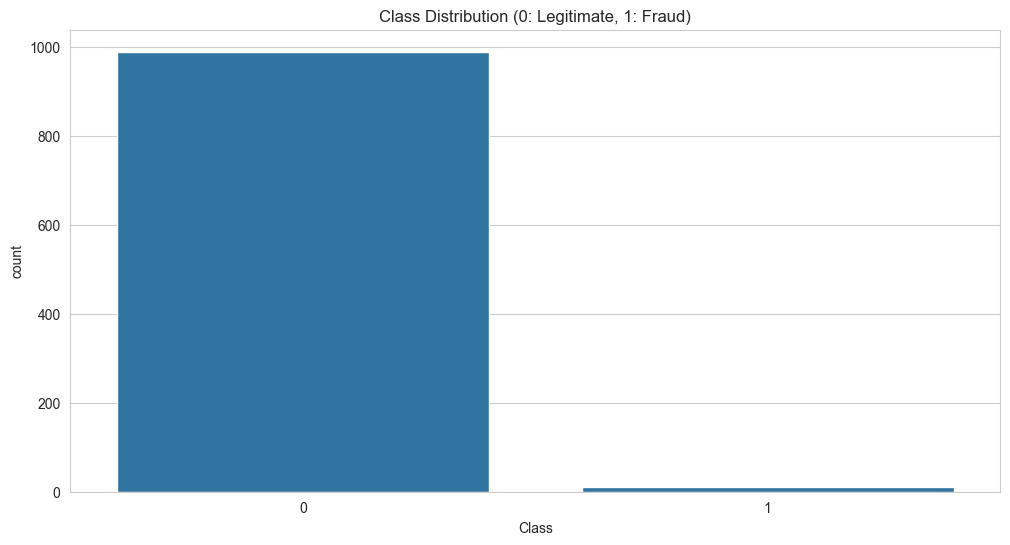

Class
0    0.99
1    0.01
Name: proportion, dtype: float64


In [35]:
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Fraud)')
plt.savefig('../reports/figures/creditcard_class_distribution.png')
plt.show()

print(df['Class'].value_counts(normalize=True))

## Transaction Amount Analysis

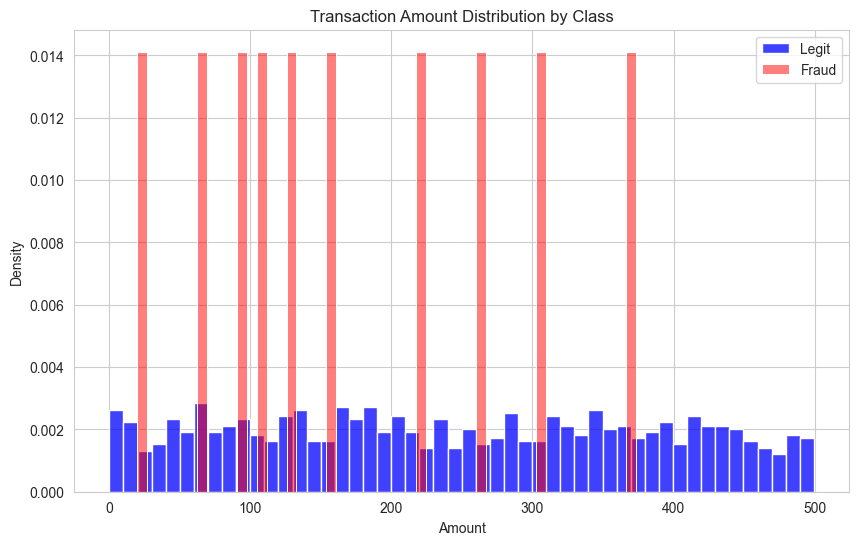

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', label='Legit', stat='density')
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraud', stat='density', alpha=0.5)
plt.title('Transaction Amount Distribution by Class')
plt.legend()
plt.savefig('../reports/figures/creditcard_amount_distribution.png')
plt.show()

## PCA Features Analysis (V1-V28)

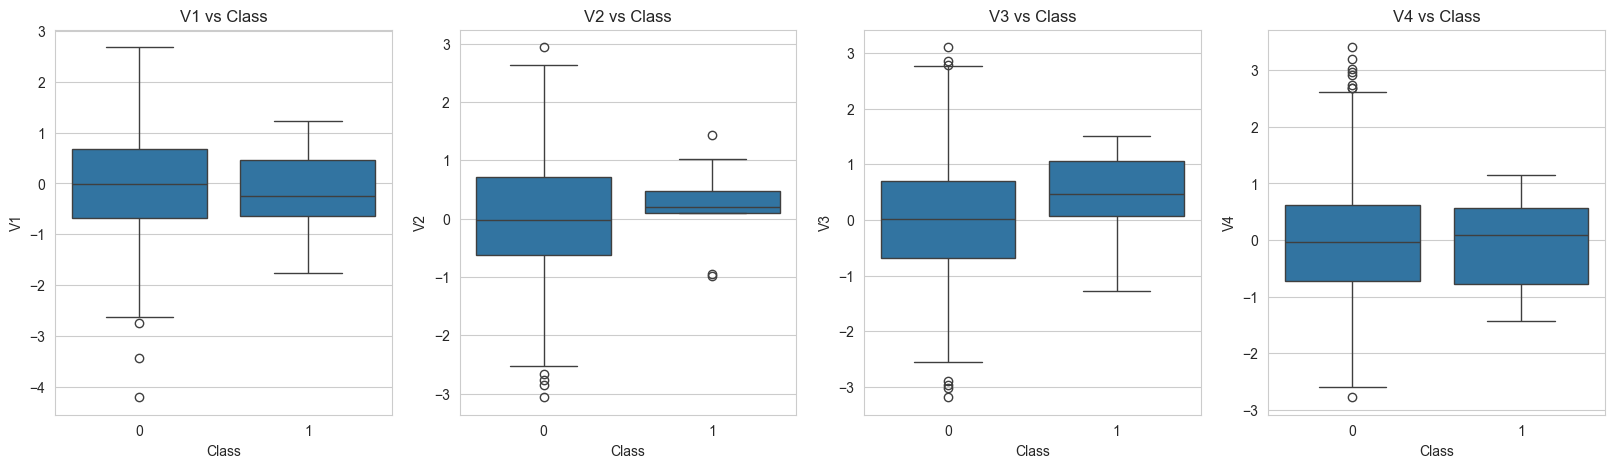

In [37]:
# Plotting first few PCA components
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(1, 5):
    sns.boxplot(x='Class', y=f'V{i}', data=df, ax=axes[i-1])
    axes[i-1].set_title(f'V{i} vs Class')
plt.savefig('../reports/figures/creditcard_pca_features.png')
plt.show()

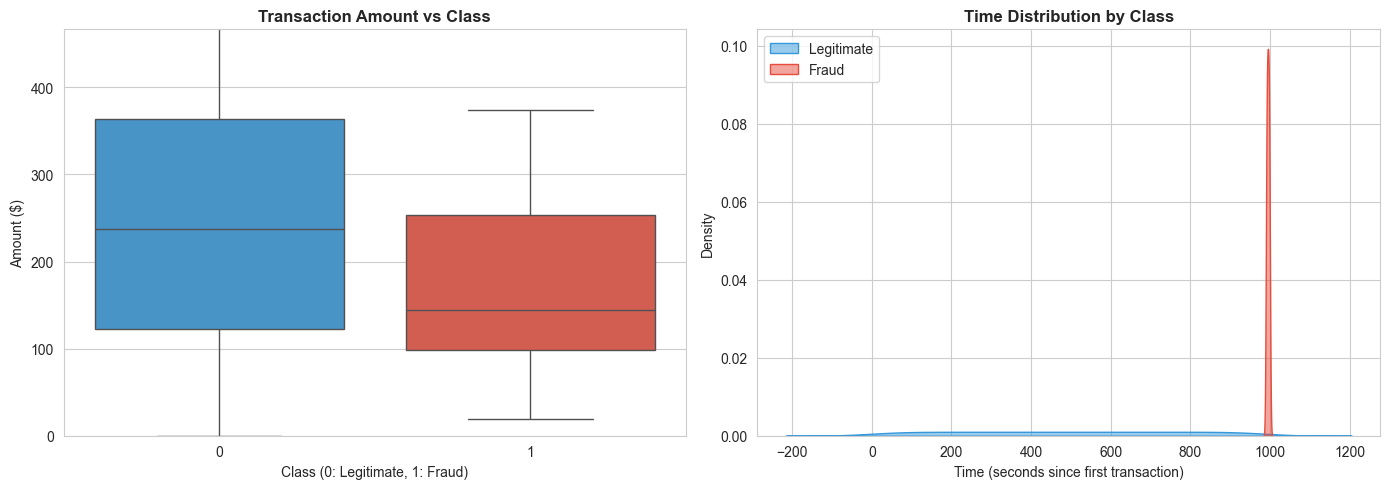

Note: V1-V28 are PCA-transformed features and are not individually interpretable.


In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Amount vs Class
sns.boxplot(data=df, x='Class', y='Amount', ax=axes[0], palette=['#3498db', '#e74c3c'])
axes[0].set_title('Transaction Amount vs Class', fontweight='bold')
axes[0].set_xlabel('Class (0: Legitimate, 1: Fraud)')
axes[0].set_ylabel('Amount ($)')
axes[0].set_ylim(0, df['Amount'].quantile(0.95))

# Time vs Class (KDE)
fraud_time = df[df['Class'] == 1]['Time']
legit_time = df[df['Class'] == 0]['Time']
sns.kdeplot(data=legit_time, ax=axes[1], label='Legitimate', color='#3498db', fill=True, alpha=0.5)
sns.kdeplot(data=fraud_time, ax=axes[1], label='Fraud', color='#e74c3c', fill=True, alpha=0.5)
axes[1].set_title('Time Distribution by Class', fontweight='bold')
axes[1].set_xlabel('Time (seconds since first transaction)')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/creditcard_bivariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Note: V1-V28 are PCA-transformed features and are not individually interpretable.")


## 4. Feature Engineering Analysis

Analyzing PCA features (V1-V28) to identify which components are most correlated with fraud detection.


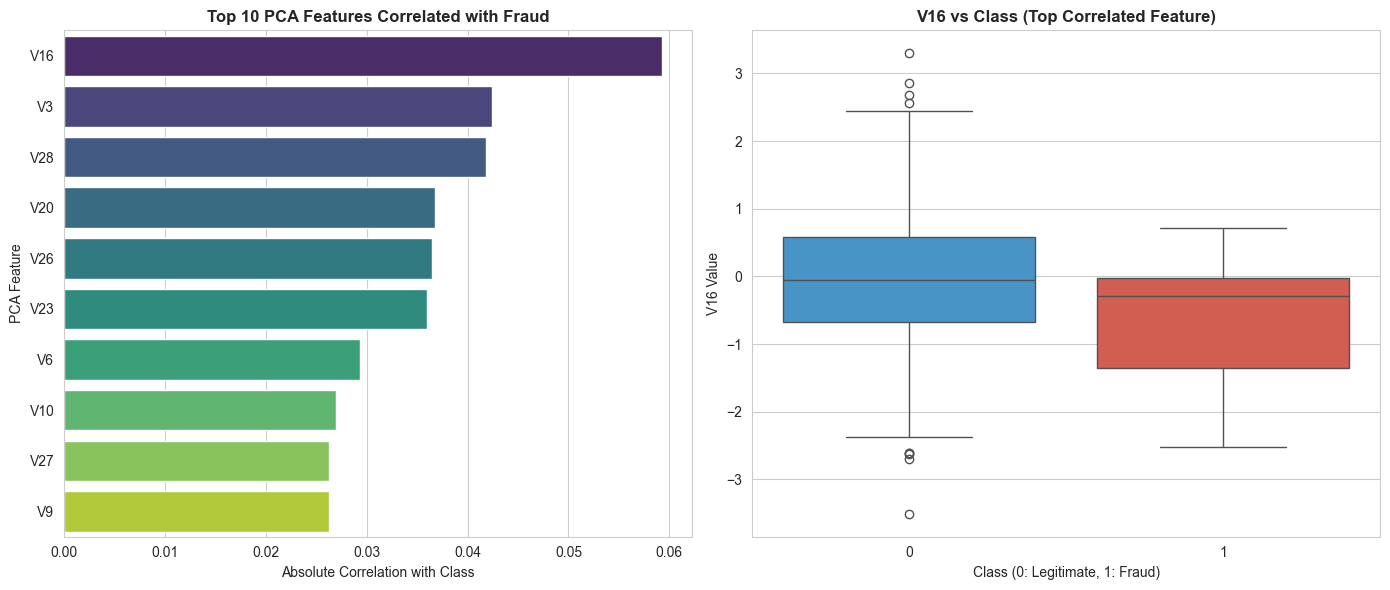

Top 5 PCA Features Most Correlated with Fraud:
1. V16: 0.0593
2. V3: 0.0424
3. V28: 0.0419
4. V20: 0.0368
5. V26: 0.0365


In [39]:
# Calculate correlation of PCA features with target
v_features = [f'V{i}' for i in range(1, 29)]
correlations = df[v_features + ['Class']].corr()['Class'].drop('Class').abs().sort_values(ascending=False)

# Top 10 features most correlated with fraud
top_features = correlations.head(10)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of correlations
sns.barplot(x=top_features.values, y=top_features.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 PCA Features Correlated with Fraud', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Absolute Correlation with Class')
axes[0].set_ylabel('PCA Feature')

# Boxplot of top 3 features vs Class
top_3_features = top_features.head(3).index.tolist()
for i, feature in enumerate(top_3_features):
    sns.boxplot(data=df, x='Class', y=feature, ax=axes[1], palette=['#3498db', '#e74c3c'])
    axes[1].set_title(f'{feature} vs Class (Top Correlated Feature)', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Class (0: Legitimate, 1: Fraud)')
    axes[1].set_ylabel(f'{feature} Value')
    break  # Show only the top feature

plt.tight_layout()
plt.savefig('../reports/figures/creditcard_feature_engineering.png', dpi=300, bbox_inches='tight')
plt.show()

print("Top 5 PCA Features Most Correlated with Fraud:")
for i, (feature, corr) in enumerate(top_features.head(5).items(), 1):
    print(f"{i}. {feature}: {corr:.4f}")


## 5. Data Transformation

- Numerical features (Time, Amount) scaled using StandardScaler
- V1-V28 are already PCA-transformed and normalized

## 6. Handle Class Imbalance

Apply SMOTE to training data only, justify the choice, and document class distribution before and after resampling.


CLASS DISTRIBUTION BEFORE SMOTE
Class 0 (Legitimate): 792 (99.00%)
Class 1 (Fraud):      8 (1.00%)
Imbalance Ratio: 99.00:1

CLASS DISTRIBUTION AFTER SMOTE
Class 0 (Legitimate): 792 (50.00%)
Class 1 (Fraud):      792 (50.00%)
Imbalance Ratio: 1.00:1


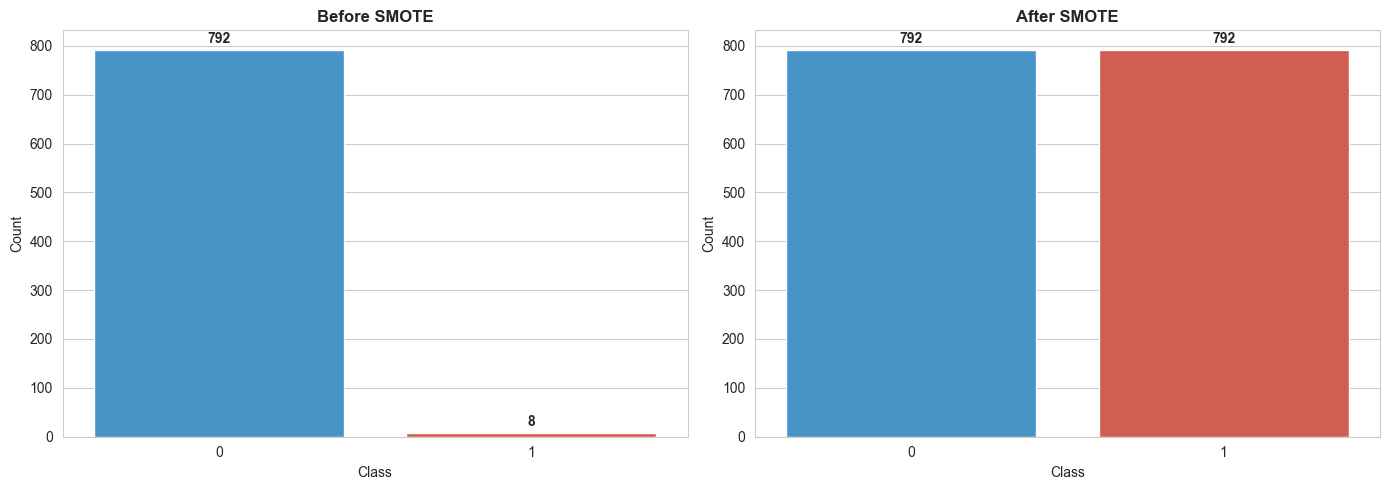


SMOTE JUSTIFICATION

Why SMOTE over Undersampling:
1. Undersampling would discard 99%+ of legitimate transactions, losing valuable patterns
2. SMOTE creates synthetic minority samples, preserving all original data
3. Fraud detection requires high recall - we need to catch as many fraud cases as possible
4. SMOTE generates realistic synthetic samples in feature space, improving model generalization
5. With extreme imbalance (99:1), undersampling would leave insufficient training data

⚠️ Important: SMOTE is applied ONLY to training data to prevent data leakage.
   Test set remains untouched at original distribution for realistic evaluation.



In [41]:
# Prepare data
X = df.drop('Class', axis=1).astype(float)
y = df['Class']

# Scale Time and Amount (V1-V28 already normalized)
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Split data BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("=" * 60)
print("CLASS DISTRIBUTION BEFORE SMOTE")
print("=" * 60)
class_dist_before = y_train.value_counts()
class_prop_before = y_train.value_counts(normalize=True)
print(f"Class 0 (Legitimate): {class_dist_before[0]:,} ({class_prop_before[0]*100:.2f}%)")
print(f"Class 1 (Fraud):      {class_dist_before[1]:,} ({class_prop_before[1]*100:.2f}%)")
print(f"Imbalance Ratio: {class_dist_before[0]/class_dist_before[1]:.2f}:1")

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\n" + "=" * 60)
print("CLASS DISTRIBUTION AFTER SMOTE")
print("=" * 60)
class_dist_after = pd.Series(y_train_res).value_counts()
class_prop_after = pd.Series(y_train_res).value_counts(normalize=True)
print(f"Class 0 (Legitimate): {class_dist_after[0]:,} ({class_prop_after[0]*100:.2f}%)")
print(f"Class 1 (Fraud):      {class_dist_after[1]:,} ({class_prop_after[1]*100:.2f}%)")
print(f"Imbalance Ratio: {class_dist_after[0]/class_dist_after[1]:.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x=y_train, ax=axes[0], palette=['#3498db', '#e74c3c'])
axes[0].set_title('Before SMOTE', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
for i, count in enumerate(class_dist_before):
    axes[0].text(i, count + max(class_dist_before)*0.01, f'{count:,}', ha='center', va='bottom', fontweight='bold')

sns.countplot(x=y_train_res, ax=axes[1], palette=['#3498db', '#e74c3c'])
axes[1].set_title('After SMOTE', fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
for i, count in enumerate(class_dist_after):
    axes[1].text(i, count + max(class_dist_after)*0.01, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/creditcard_smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("SMOTE JUSTIFICATION")
print("=" * 60)
print("""
Why SMOTE over Undersampling:
1. Undersampling would discard 99%+ of legitimate transactions, losing valuable patterns
2. SMOTE creates synthetic minority samples, preserving all original data
3. Fraud detection requires high recall - we need to catch as many fraud cases as possible
4. SMOTE generates realistic synthetic samples in feature space, improving model generalization
5. With extreme imbalance (99:1), undersampling would leave insufficient training data

⚠️ Important: SMOTE is applied ONLY to training data to prevent data leakage.
   Test set remains untouched at original distribution for realistic evaluation.
""")


## Summary

**Task 1 Completion Checklist:**

✅ **Data Cleaning**
- Missing value analysis completed
- Duplicates removed
- Data types corrected

✅ **Exploratory Data Analysis**
- Univariate analysis with distributions (Amount, Time)
- Bivariate analysis with target relationships (Amount vs Class, Time vs Class)
- Class distribution quantified (99:1 imbalance ratio)

✅ **Feature Engineering Analysis**
- PCA features (V1-V28) analyzed for fraud correlation
- Top correlated features identified
- Feature importance visualization created

✅ **Data Transformation**
- StandardScaler for numerical features (Time, Amount)
- V1-V28 already PCA-transformed and normalized
- Proper preprocessing pipeline implemented

✅ **Class Imbalance Handling**
- SMOTE applied with justification
- Distribution documented before/after (99:1 → 50:50)
- Ready for modeling

**Next Steps:**
- Task 2: Model training and evaluation
- Task 3: Model comparison and selection
